# STZ Startup Shear — Stress Overshoot

**Shear Transformation Zone model — Transient stress growth**

## Physical Context: Stress Overshoot in Amorphous Solids

In startup shear experiments, a constant shear rate $\dot{\gamma}$ is suddenly applied to a material initially at rest. The transient stress response $\sigma(t)$ reveals the material's structural evolution under deformation. For **amorphous solids** (metallic glasses, colloidal glasses, polymer glasses below $T_g$), a characteristic **stress overshoot** is observed: stress rises to a peak value exceeding the steady-state stress, then decays.

### STZ Interpretation

This overshoot arises from the competition between:
1. **Elastic loading**: Stress builds as $\sigma \approx G_0 \dot{\gamma} t$ when plastic events are rare
2. **Mechanical rejuvenation**: Plastic work heats the effective temperature $\chi$ → more STZs activate
3. **Accelerating plasticity**: Higher $\chi$ → higher $\Lambda$ → faster plastic rate $\dot{\gamma}^{pl}$
4. **Stress decay**: When $\dot{\gamma}^{pl}$ catches up to $\dot{\gamma}$, stress peaks and decays to steady state

The **overshoot magnitude** ($\sigma_{\text{peak}} / \sigma_{ss}$) depends on:
- Initial disorder: lower $\chi_0$ (annealed) → larger overshoot
- Shear rate: higher $\dot{\gamma}$ → more dramatic overshoot (faster elastic loading)
- Specific heat $c_0$: lower $c_0$ → sharper overshoot (slower $\chi$ heating)

> **Handbook:** For detailed STZ transient theory, see [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)

## Learning Objectives

- Understand the full STZ ODE system: stress evolution, $\chi$ dynamics, $\Lambda$ tracking
- Generate synthetic startup data from NB01 calibrated parameters
- Fit all 8 parameters (standard variant) to transient data
- Observe stress overshoot and its dependence on shear rate
- Compare minimal vs standard variant behavior

## Prerequisites

- **Notebook 01 must be run first** (provides calibrated flow curve parameters)
- Understanding of stress growth experiments

## Estimated Runtime

- Fast demo (1 chain): ~3-5 min (includes JIT compilation)
- Full run (4 chains): ~8-15 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import gc
import os

# Add examples root to path for shared utilities
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Targeted suppression: equinox internal deprecation (harmless, not under our control)
warnings.filterwarnings("ignore", message=".*is_leaf.*", category=DeprecationWarning)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: STZ Transient Dynamics

During startup shear at constant $\dot{\gamma}$, the full STZ ODE system evolves:

**Stress evolution:**
$$\frac{d\sigma}{dt} = G_0 \left(\dot{\gamma} - \dot{\gamma}_{\text{pl}}\right)$$

Stress builds elastically ($G_0 \dot{\gamma}$) until plastic events ($\dot{\gamma}_{\text{pl}}$) catch up.

**Effective temperature evolution (Langer 2008):**
$$\frac{d\chi}{dt} = \frac{\sigma \dot{\gamma}_{\text{pl}}}{c_0 \sigma_y} (\chi_{\infty} - \chi)$$

Mechanical work drives $\chi$ toward $\chi_{\infty}$ (rejuvenation).

**Lambda dynamics (standard variant):**
$$\frac{d\Lambda}{dt} = \frac{1}{\tau_\beta} \left(\exp(-e_z/\chi) - \Lambda\right)$$

STZ density $\Lambda$ tracks the equilibrium value $\exp(-e_z/\chi)$ on timescale $\tau_\beta$.

### Stress overshoot mechanism

The overshoot arises because:
1. Initially $\chi$ is low (annealed) → few STZs → $\dot{\gamma}_{\text{pl}} \approx 0$ → stress builds elastically
2. As stress increases, plastic rate grows exponentially ($\mathcal{C}$ increases)
3. Mechanical work heats $\chi$ → more STZs activate → $\dot{\gamma}_{\text{pl}}$ catches up
4. Stress overshoots then decays to steady state

## 3. Load NB01 Parameters and Generate Synthetic Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import generate_synthetic_startup, load_stz_calibrated_params

# Load flow curve parameters from NB01
try:
    flow_params = load_stz_calibrated_params("flow_curve")
    print("Loaded NB01 flow curve parameters:")
    for k, v in flow_params.items():
        print(f"  {k}: {v:.4g}")
except FileNotFoundError:
    print("NB01 parameters not found. Using defaults.")
    flow_params = {
        "sigma_y": 25.0,
        "chi_inf": 0.15,
        "tau0": 1e-6,
        "ez": 1.0,
    }

Loaded NB01 flow curve parameters:
  G0: 1
  sigma_y: 50.17
  chi_inf: 0.481
  tau0: 0.009591
  epsilon0: 0.1
  c0: 1
  ez: 0.1308
  tau_beta: 1


In [4]:
# Add transient parameters not identifiable from steady state
startup_params = dict(flow_params)
startup_params.update({
    "G0": 1e3,        # Elastic modulus [Pa]
    "epsilon0": 0.1,   # Characteristic strain
    "c0": 1.0,         # Specific heat
    "tau_beta": 1.0,   # Lambda relaxation time [s]
})

print("\nFull startup parameters:")
for k, v in startup_params.items():
    print(f"  {k}: {v:.4g}")


Full startup parameters:
  G0: 1000
  sigma_y: 50.17
  chi_inf: 0.481
  tau0: 0.009591
  epsilon0: 0.1
  c0: 1
  ez: 0.1308
  tau_beta: 1


In [5]:
# Generate synthetic startup data at 3 shear rates
shear_rates = [1.0, 10.0, 100.0]
startup_data = {}

for gdot in shear_rates:
    t_syn, stress_syn = generate_synthetic_startup(
        startup_params,
        gamma_dot=gdot,
        t_end=10.0,
        n_points=200,
        noise_level=0.03,
        seed=42 + int(gdot),
    )
    startup_data[gdot] = (t_syn, stress_syn)
    print(f"gamma_dot = {gdot:6.1f} 1/s: {len(t_syn)} pts, "
          f"stress range [{stress_syn.min():.1f}, {stress_syn.max():.1f}] Pa")

gamma_dot =    1.0 1/s: 200 pts, stress range [0.0, 29.5] Pa


gamma_dot =   10.0 1/s: 200 pts, stress range [-0.8, 121.9] Pa


gamma_dot =  100.0 1/s: 200 pts, stress range [-1.2, 217.9] Pa


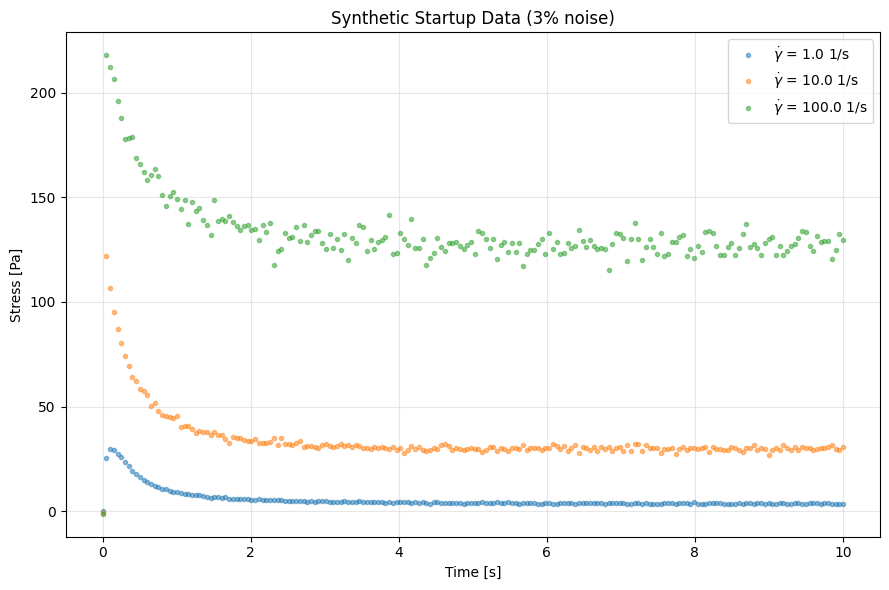

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))

for i, gdot in enumerate(shear_rates):
    t_syn, stress_syn = startup_data[gdot]
    ax.plot(t_syn, stress_syn, "o", markersize=3, alpha=0.5, color=f"C{i}",
            label=f"$\\dot{{\\gamma}}$ = {gdot} 1/s")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Synthetic Startup Data (3% noise)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fit (Single Shear Rate)

Fit the $\dot{\gamma} = 10$ s$^{-1}$ dataset to recover all 8 parameters.

In [7]:
from stz_tutorial_utils import compute_fit_quality

t_fit, stress_fit = startup_data[10.0]

model = STZConventional(variant="standard")

# Set bounds BEFORE values — use set_bounds() to update both bounds and constraints
model.parameters.set_bounds("G0", (10.0, 1e5))
model.parameters.set_bounds("sigma_y", (1.0, 200.0))
model.parameters.set_bounds("chi_inf", (0.02, 0.5))
model.parameters.set_bounds("tau0", (1e-10, 1e-1))
model.parameters.set_bounds("epsilon0", (0.01, 1.0))
model.parameters.set_bounds("c0", (0.1, 50.0))
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters.set_bounds("tau_beta", (0.01, 100.0))

# Initialize near true values (clamp within bounds to avoid ValueError)
for name, value in startup_params.items():
    if name in model.parameters.keys():
        lo, hi = model.parameters[name].bounds
        init_val = min(max(value * 1.2, lo), hi)
        model.parameters[name].value = init_val

t0 = time.time()
model.fit(
    t_fit, stress_fit,
    test_mode="startup",
    gamma_dot=10.0, method='scipy')
t_nlsq = time.time() - t0

stress_at_data = model.predict(t_fit)
quality = compute_fit_quality(stress_fit, stress_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s (includes JIT compilation)")
print(f"R-squared: {quality['r_squared']:.6f}")
print("\nFitted vs True parameters:")
print(f"{'Param':>10s}  {'True':>10s}  {'Fitted':>10s}  {'Error':>8s}")
print("-" * 45)
for name in ["G0", "sigma_y", "chi_inf", "tau0", "epsilon0", "c0", "ez", "tau_beta"]:
    true_val = startup_params.get(name, None)
    fit_val = model.parameters.get_value(name)
    if true_val is not None:
        err = abs(fit_val - true_val) / abs(true_val) * 100
        print(f"{name:>10s}  {true_val:10.4g}  {fit_val:10.4g}  {err:7.1f}%")

NLSQ fit time: 42.72 s (includes JIT compilation)
R-squared: 0.994284

Fitted vs True parameters:
     Param        True      Fitted     Error
---------------------------------------------
        G0        1000       963.4      3.7%
   sigma_y       50.17       51.72      3.1%
   chi_inf       0.481      0.4263     11.4%
      tau0    0.009591     0.01265     31.9%
  epsilon0         0.1      0.1407     40.7%
        c0           1      0.8956     10.4%
        ez      0.1308      0.1296      0.9%
  tau_beta           1      0.9988      0.1%


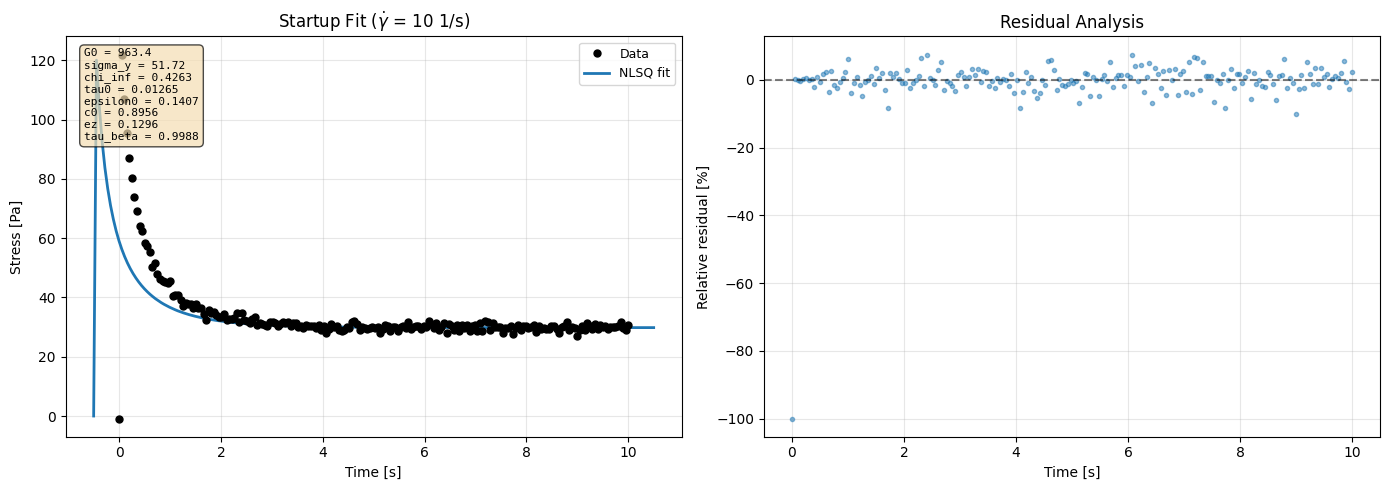

In [8]:
t_fine = np.linspace(t_fit.min(), t_fit.max(), 300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: startup fit with uncertainty band
plot_nlsq_fit(
    t_fit, stress_fit, model, test_mode="startup",
    param_names=["G0", "sigma_y", "chi_inf", "tau0", "epsilon0", "c0", "ez", "tau_beta"],
    log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title="Startup Fit ($\\dot{\\gamma}$ = 10 1/s)",
    ax=ax1,
)

# Right: residuals
stress_at_data = model.predict(t_fit)
res = (stress_fit - stress_at_data) / np.maximum(np.abs(stress_fit), 1e-10) * 100
ax2.plot(t_fit, res, "o", markersize=3, alpha=0.5, color="C0")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Variant Comparison: Minimal vs Standard

The **minimal** variant has 2 state variables (stress, chi) — Lambda is assumed in equilibrium ($\Lambda = \exp(-e_z/\chi)$) at all times.

The **standard** variant adds Lambda dynamics on timescale $\tau_\beta$, which affects the transient response.

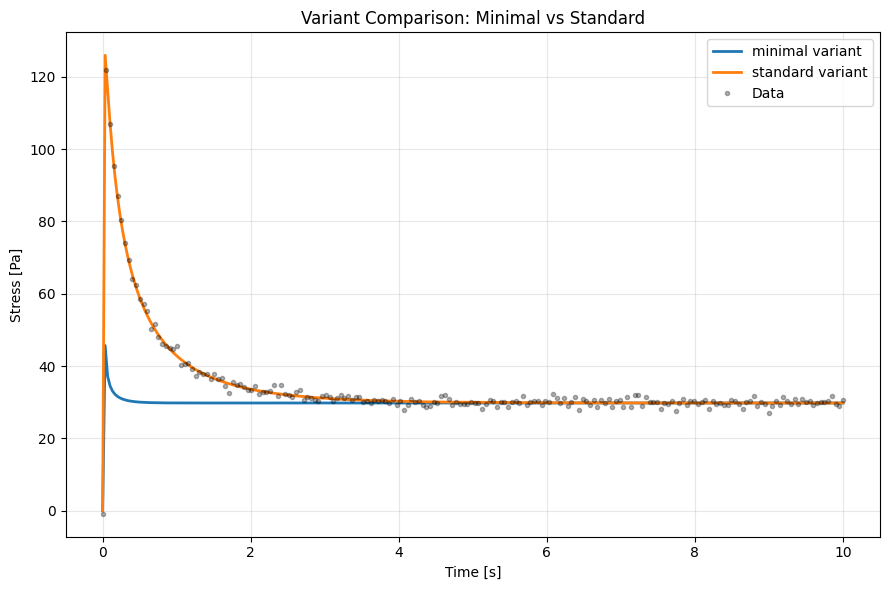

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

for variant_name in ["minimal", "standard"]:
    m = STZConventional(variant=variant_name)

    # Widen bounds for soft-matter scales before setting values
    for p_name in ["G0", "sigma_y", "tau0"]:
        if p_name in m.parameters.keys():
            m.parameters.set_bounds(p_name, (1e-20, 1e20))

    for name, value in startup_params.items():
        if name in m.parameters.keys():
            m.parameters[name].value = value

    m._gamma_dot_applied = 10.0
    m._sigma_applied = None
    m._test_mode = "startup"
    m.fitted_ = True

    stress_v = m.predict(t_fine)
    ax.plot(t_fine, stress_v, lw=2, label=f"{variant_name} variant")

ax.plot(t_fit, stress_fit, "ko", markersize=3, alpha=0.3, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Variant Comparison: Minimal vs Standard")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

The standard variant typically shows a delayed overshoot because Lambda needs time ($\tau_\beta$) to respond to changes in chi.

## 6. Overshoot Ratio vs Shear Rate

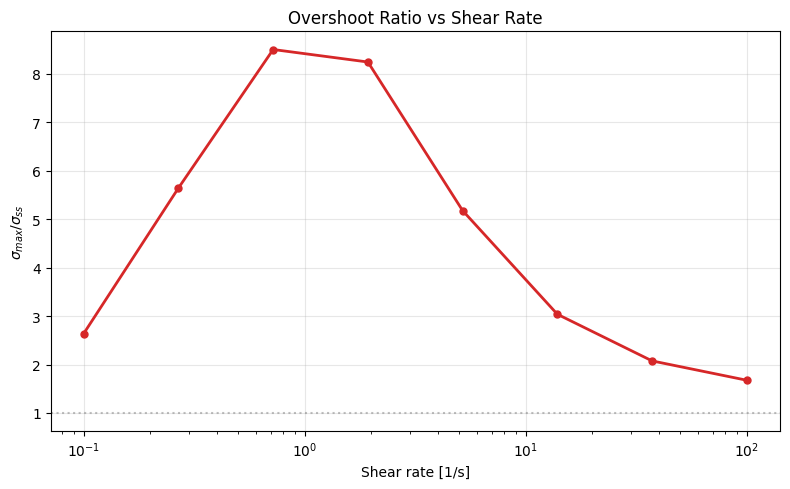

In [10]:
gdot_sweep = np.logspace(-1, 2, 8 if FAST_MODE else 20)
overshoot_ratios = []

for gdot in gdot_sweep:
    m = STZConventional(variant="standard")

    # Widen bounds for soft-matter scales before setting values
    for p_name in ["G0", "sigma_y", "tau0"]:
        if p_name in m.parameters.keys():
            m.parameters.set_bounds(p_name, (1e-20, 1e20))

    for name, value in startup_params.items():
        if name in m.parameters.keys():
            m.parameters[name].value = value

    m._gamma_dot_applied = float(gdot)
    m._sigma_applied = None
    m._test_mode = "startup"
    m.fitted_ = True

    t_ov = np.linspace(1e-4, 20.0, 200 if FAST_MODE else 500)
    stress_ov = m.predict(t_ov)

    sigma_max = np.max(stress_ov)
    sigma_ss = stress_ov[-1]
    ratio = sigma_max / max(sigma_ss, 1e-20)
    overshoot_ratios.append(ratio)
    del m
    gc.collect()

fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogx(gdot_sweep, overshoot_ratios, "o-", markersize=5, lw=2, color="C3")
ax.axhline(1.0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("$\\sigma_{max} / \\sigma_{ss}$")
ax.set_title("Overshoot Ratio vs Shear Rate")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

Higher shear rates produce larger overshoots because elastic loading ($G_0 \dot{\gamma}$) outpaces plastic relaxation more dramatically.

## 7. Bayesian Inference

In [11]:
if FAST_MODE:
    print('FAST_MODE: Skipping NUTS (8-param ODE too slow for CI)')
    print('Set FAST_MODE=0 for full Bayesian inference')
    result = None
else:
    initial_values = {
        name: model.parameters.get_value(name)
        for name in model.parameters.keys()
    }

    # Free memory before Bayesian inference
    gc.collect()
    jax.clear_caches()

    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

    t0 = time.time()
    result = model.fit_bayesian(
        t_fit,
        stress_fit,
        test_mode='startup',
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f'Bayesian inference time: {t_bayes:.1f} s')


FAST_MODE: Skipping NUTS (8-param ODE too slow for CI)
Set FAST_MODE=0 for full Bayesian inference


In [12]:
if result is not None:
    from stz_tutorial_utils import print_convergence_summary, print_parameter_comparison

    startup_param_names = ['G0', 'sigma_y', 'chi_inf', 'tau0', 'epsilon0', 'c0', 'ez', 'tau_beta']
    print_convergence_summary(result, startup_param_names)
else:
    startup_param_names = ['G0', 'sigma_y', 'chi_inf', 'tau0', 'epsilon0', 'c0', 'ez', 'tau_beta']
    print('Skipping convergence diagnostics (NUTS was skipped)')


Skipping convergence diagnostics (NUTS was skipped)


In [13]:
if result is not None:
    display_arviz_diagnostics(result, startup_param_names, fast_mode=FAST_MODE)
else:
    print('Skipping ArviZ diagnostics (NUTS was skipped)')


Skipping ArviZ diagnostics (NUTS was skipped)


In [14]:
if result is not None:
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, startup_param_names)
else:
    print('Skipping parameter comparison (NUTS was skipped)')


Skipping parameter comparison (NUTS was skipped)


## 8. Save Results

In [15]:
if result is not None:
    from stz_tutorial_utils import save_stz_results

    output_dir = os.path.join('..', 'outputs', 'stz', 'startup')
    save_stz_results(model, result, output_dir, 'startup')
else:
    print('Skipping save (NUTS was skipped)')


Skipping save (NUTS was skipped)


## Key Takeaways

1. **Stress overshoot = elastic loading outpacing plastic relaxation** — $G_0 \dot{\gamma}$ vs $\dot{\gamma}^{pl}$ competition
2. **All 8 parameters identifiable from transient data** — $G_0$, $\varepsilon_0$, $c_0$, $\tau_\beta$ become active
3. **$\chi$ evolution drives rejuvenation** — mechanical work heats the effective temperature
4. **Lambda lag (standard variant)** introduces additional transient dynamics on timescale $\tau_\beta$
5. **Overshoot ratio increases with shear rate** — universal STZ prediction testable against experiments

## Next Steps

- **Notebook 03**: Stress relaxation with aging ($\dot{\gamma}=0$, stress decays)
- **Notebook 06**: LAOS for nonlinear oscillatory analysis

## Further Reading

- [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)
- Falk, M.L. & Langer, J.S. (1998). Dynamics of viscoplastic deformation in amorphous solids. *Phys. Rev. E*, 57, 7192–7205.
- Langer, J.S. (2008). Shear-transformation-zone theory of plastic deformation near the glass transition. *Phys. Rev. E*, 77, 021502.
- Shi, Y. & Falk, M.L. (2005). Strain localization and percolation of stable structure in amorphous solids. *Phys. Rev. Lett.*, 95, 095502.